# Creation of a csv file for an LFP electrode array

### In this notebook, we create an LFP file for a 6x10 grid of contacts, with 20 um spacing, in a plane parallel to the neuron

In [10]:
import numpy as np
import bluepysnap as bp
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

## Extract population object from simulation config file

In [11]:
path_to_simconfig = '../../data/simulation/simulation_config.json'

rSim = bp.Simulation(path_to_simconfig)
r = rSim.reports[list(rSim.reports.keys())[0]] # We assume that the compartment report is the only report produced by the simulation

circuit = rSim.circuit

population_name = r.population_names[0]

population = rSim.circuit.nodes[population_name]

## Get center and orientation of cell

In [12]:
i = 0 # Node_ID for the cell

center = np.array([population.get(group=[i],properties='x'),population.get(group=[i],properties='y'),population.get(group=[i],properties='z')]) # Gets soma position

center = center.flatten()

### Gets orientation of the cell in the circuit
rotW = population.get(group=[i],properties='orientation_w')
rotX = population.get(group=[i],properties='orientation_x')
rotY = population.get(group=[i],properties='orientation_y')
rotZ = population.get(group=[i],properties='orientation_z')
####

### Creates rotation quaternion for cell
rotQuat = np.array([rotX,rotY,rotZ,rotW])
rotQuat /= np.linalg.norm(rotQuat)
rotation = R.from_quat(rotQuat.flatten())
###

In [13]:
center

array([ 4588.59864738, -1398.5694477 , -3422.00727189])

## Define electrode array

In [14]:
xpos = np.arange(-3,3)*200
ypos = np.arange(-3,7)*200

idx = 0

for x in xpos:
    for y in ypos:
        
        contact_location = np.array([x,y,400]).reshape(1,3)
        
        if idx == 0:
            electrode_array = contact_location
            idx += 1
        else:
            electrode_array = np.vstack((electrode_array,contact_location))
            
electrode_array_original = electrode_array

electrode_array = R.apply(rotation,electrode_array)

electrode_array += center

## Visualize cell and array

<IPython.core.display.Javascript object>


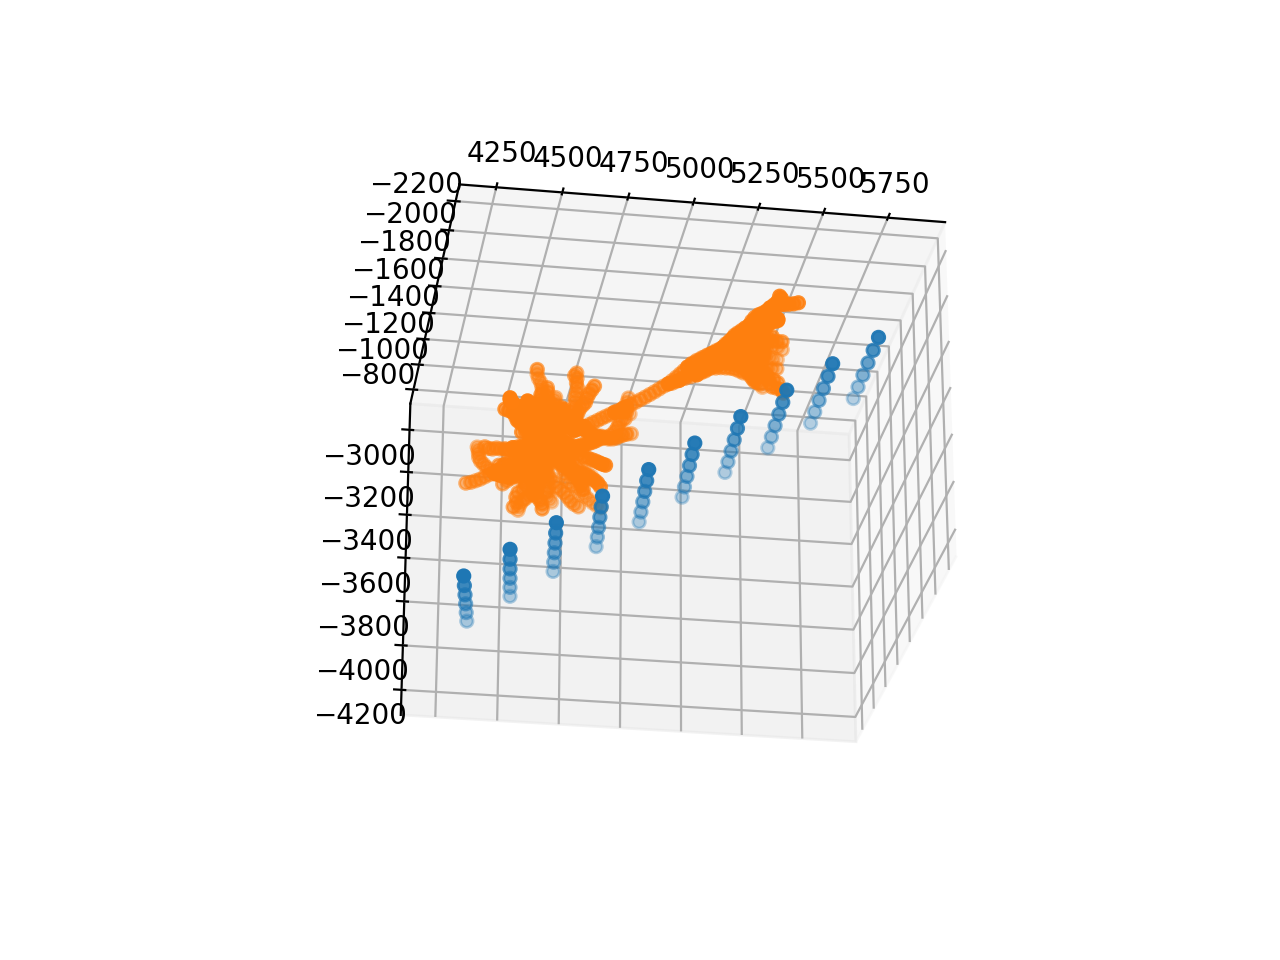

In [16]:
cell_positions = pd.read_pickle('../../data/getPositions/positions/0/positions0.pkl')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(electrode_array[:,0],electrode_array[:,1],electrode_array[:,2])
ax.scatter(cell_positions.values[0,:],cell_positions.values[1,:],cell_positions.values[2,:])


## Write csv file

In [17]:
electrode_csv = 'lfp.csv'

numContacts = electrode_array.shape[0]


regionList = []
layerList = []
for i in range(numContacts):
    regionList.append('Outside')
    layerList.append('Outside')

electrodeData = pd.DataFrame(data=electrode_array,columns=['x','y','z'])

layerData = pd.DataFrame(data=layerList,columns=['layer'])

regionData = pd.DataFrame(data=regionList,columns=['region'])

data = pd.concat((electrodeData,layerData),axis=1)
data = pd.concat((data,regionData),axis=1)


data.to_csv(electrode_csv)